# Random Forests

In [1]:
#Import all required libraries for reading data, analysing and visualizing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [2]:
from pandas.api.types import is_string_dtype, is_numeric_dtype
from concurrent.futures import ProcessPoolExecutor
import math
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz
import graphviz
import IPython
from sklearn.tree import export_graphviz

# Data

Kaggle provides info about some of the fields of our dataset; on the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) page they say the following:

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the uniue identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

In [3]:
btrain = pd.read_csv('train.csv', parse_dates=['saledate'], low_memory=False )
btrain.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
??pd.option_context

In [5]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000): 
        display(df)

In [6]:
display_all(btrain.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [7]:
btrain.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    258360
UsageBand                   331486
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             137191
fiModelSeries               344217
fiModelDescriptor           329206
ProductSize                 210775
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                296764
Enclosure                      325
Forks                       209048
Pad_Type                    321991
Ride_Control                252519
Stick                       321991
Transmission                217895
Turbocharged                321991
Blade_Extension     

In [8]:
display_all(btrain.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
btrain.SalePrice = np.log(btrain.SalePrice)

## Initial Processing

In [10]:
model = RandomForestRegressor()
model.fit(btrain.drop('SalePrice', axis=1), btrain.SalePrice)

ValueError: could not convert string to float: 'Conventional'

In [11]:
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.

    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    """
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [12]:
add_datepart(btrain,'saledate')
btrain.tail().T

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,9.25913,9.30565,9.3501,9.10498,8.95545
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,35NX2,35NX2,35NX2,30NX,30NX


In [18]:
len(btrain)

401125

In [19]:
for n,c in btrain.items():
        if is_string_dtype(c): btrain[n] = c.astype('category').cat.as_ordered()

In [20]:
btrain.tail().T

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,9.25913,9.30565,9.3501,9.10498,8.95545
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,35NX2,35NX2,35NX2,30NX,30NX


In [21]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.

    Parameters:
    -----------
    df: The data frame you wish to process.

    y_fld: The name of the response variable

    skip_flds: A list of fields that dropped from df.

    ignore_flds: A list of fields that are ignored during processing.

    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)

    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.

    preproc_fn: A function that gets applied to df.

    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.

    subset: Takes a random subset of size subset from df.

    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).

    Returns:
    --------
    [x, y, nas, mapper(optional)]:

        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.

        y: y is the response variable

        nas: returns a dictionary of which nas it created, and the associated median.

        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.

    Parameters:
    -----------
    df: The data frame that will be changed.

    col: The column of data to fix by filling in missing data.

    name: The name of the new filled column in df.

    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict
def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.

    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.

    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.

    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1

In [22]:
btrain_proc, y, nas = proc_df(btrain, y_fld='SalePrice')

In [29]:
btrain_proc.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,2,2,1,1,3
fiModelDesc,950,1725,331,3674,4208
fiBaseModel,296,527,110,1375,1529


In [24]:
btrain.shape, btrain_proc.shape, y.shape

((401125, 65), (401125, 66), (401125,))

In [28]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(btrain_proc, y)
model.score(btrain_proc, y)

0.98289858568911515

In [30]:
len(btrain), len(btrain_proc)

(401125, 401125)

In [104]:
def split_vals(df,n): return df[:n].copy(), df[n:].copy()

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): 
        res.append(m.oob_score_)
        print('RMSE Train:',res[0], '\n','RMSE Valid:', res[1], '\n','Score Train:', res[2], 
              '\n','Score Valid:', res[3], '\n', 'OOB Score:', res[4])
    else: print('RMSE Train:',res[0], '\n','RMSE Valid:', res[1], '\n','Score Train:', res[2], 
          '\n','Score Valid:', res[3])

In [32]:
n_valid = 12000  # same as Kaggle's test set size
n_trn = len(btrain_proc)-n_valid
raw_train, raw_valid = split_vals(btrain, n_trn)
X_train, X_valid = split_vals(btrain_proc, n_trn)
y_train, y_valid = split_vals(y, n_trn)

raw_train.shape, raw_valid.shape, X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((389125, 65), (12000, 65), (389125, 66), (12000, 66), (389125,), (12000,))

### If something takes more than 10s time, then interaction validation becomes difficult. 

In [70]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1.91 s
RMSE Train: 0.1109709243468655 
 RMSE Valid: 0.3645731326803371 
 Score Train: 0.972451438195 
 Score Valid: 0.762634665275


# Speeding things...

In [35]:
def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.

    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.

    Returns:
    --------
    return value: A random sample of n rows of df.
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

##### Validation set will be kept the same all thru. 

In [71]:
# We are just getting random subset of 30000 from btrain
df_trn, y_trn, nas = proc_df(btrain, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [72]:
df_trn.shape, y_trn.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, nas

((30000, 66),
 (30000,),
 (20000, 66),
 (20000,),
 (12000, 66),
 (12000,),
 {'MachineHoursCurrentMeter': 0.0, 'auctioneerID': 2.0})

Wall time: 44 s  
[0.09077561077091424, 0.24988993416906555, 0.98277841238608399, 0.88848186462134215]  

In [73]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1.76 s
RMSE Train: 0.11119410238065017 
 RMSE Valid: 0.35227770104898365 
 Score Train: 0.972704126091 
 Score Valid: 0.778375238641


# Single Tree

In [74]:
# Forest with one tree (n_estimators)
# tree consists of a sequence of binary decisions/splits. 
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

RMSE Train: 0.5223778245838965 
 RMSE Valid: 0.5816975291361277 
 Score Train: 0.397575034343 
 Score Valid: 0.395714167799


In [41]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.

    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

In [42]:
m.estimators_ #m_estimators is 1

[DecisionTreeRegressor(criterion='mse', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=2049253027, splitter='best')]

In [46]:
??draw_tree

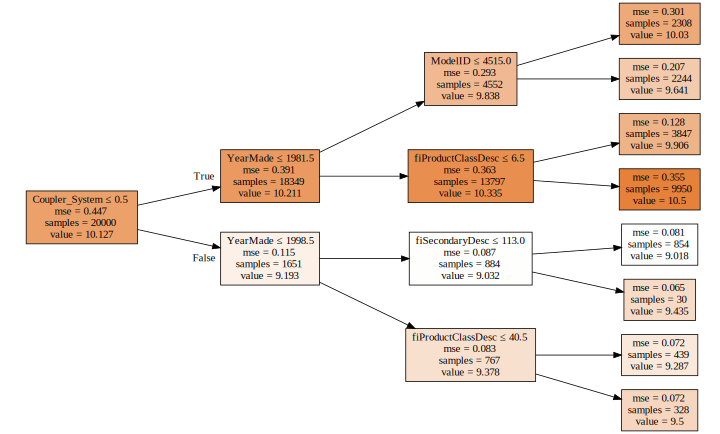

In [47]:
draw_tree(m.estimators_[0], df_trn, precision=3)

### How do we pick which variable and which split?
- At each binary point, we have to identify the variable and then do the split. How do we identify the variable and do the split?
- Find a variable which splits into different groups.. Which variable and which split point???
- test all the possible splits and find the one that has small rmse??? How do we enumerate all the possible splits
- For each variable, for each possible value of the variable we see whether it is better... What do we mean when we say that the rmse is better...
- If we just consider rmse, then it will not be a great split due to the sample size. To avoid this, we can take the weighted average of the mean squared error.

In [48]:
# tree consists of a sequence of binary decisions/splits. 
# m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
# [0.5151880932929396, 0.5832476542732743, 0.40623832985553088, 0.39248923831352289]

In [75]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

RMSE Train: 4.351167857633658e-17 
 RMSE Valid: 0.4595582979640202 
 Score Train: 1.0 
 Score Valid: 0.622836898322


The training set result looks great! But the validation set is worse than our original model. This is why we need to use bagging of multiple trees to get more generalizable results.

# Bagging

### We want to find some other way to making these trees better. For this, we need to create forests aka bagging. We can do for any kind of model.
Random forest is a way of bagging trees. 

In [76]:
m = RandomForestRegressor(n_jobs=-1) #default n_estimators is 10
m.fit(X_train, y_train)
print_score(m)

RMSE Train: 0.11140245488976624 
 RMSE Valid: 0.3806351351940673 
 Score Train: 0.97260173771 
 Score Valid: 0.741258720039


In [52]:
m.estimators_

[DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=142762995, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1670179291, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=433399475, splitter='best'),
 DecisionTreeRegresso

In [77]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

In [54]:
preds.shape

(10, 12000)

In [55]:
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.04782144,  9.39266193,  9.04782144,  9.15904708,  9.04782144,
         9.15904708,  8.98719682,  9.87816974,  9.39266193,  9.39266193]),
 9.2504910834136727,
 9.1049798563183568)

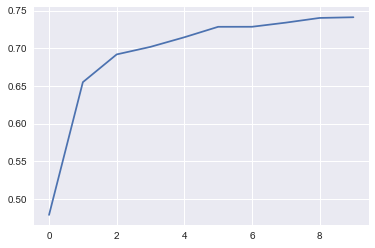

In [78]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [79]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

RMSE Train: 0.100397764221616 
 RMSE Valid: 0.3437451683993976 
 Score Train: 0.97774735807 
 Score Valid: 0.788981185393


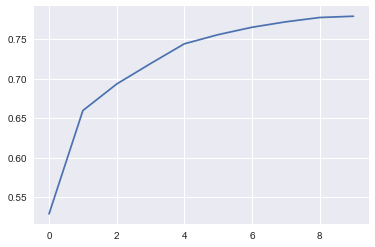

In [80]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [81]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

RMSE Train: 0.09594554759781387 
 RMSE Valid: 0.3497777492192299 
 Score Train: 0.979677218475 
 Score Valid: 0.781509614183


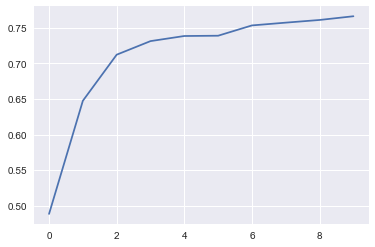

In [82]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [83]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

RMSE Train: 0.09211733630267173 
 RMSE Valid: 0.3478137813195565 
 Score Train: 0.98126661584 
 Score Valid: 0.783956330162


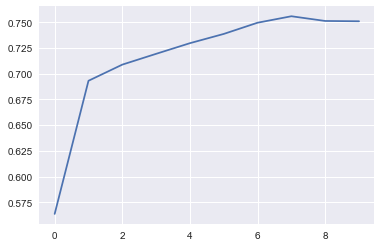

In [84]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check.

# OOB Score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called out-of-bag (OOB) error which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was not included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our print_score function below.

In [85]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train: 0.09567610796101451 
 RMSE Valid: 0.3606295928056721 
 Score Train: 0.97979120134 
 Score Valid: 0.767741991962 
 OOB Score: 0.855458905206
RMSE Train: 0.09567610796101451 
 RMSE Valid: 0.3606295928056721 
 Score Train: 0.97979120134 
 Score Valid: 0.767741991962


# Reducing overfitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: subsampling. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [86]:
df_trn, y_trn, nas = proc_df(btrain, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a different random subset per tree. That way, given enough trees, the model can still see all the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [96]:
n_trn, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(389125, (389125, 66), (389125,), (12000, 66), (12000,))

In [94]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))    

In [95]:
set_rf_samples(20000)

In [97]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 7.9 s
RMSE Train: 0.24132290179894755 
 RMSE Valid: 0.28109546128470875 
 Score Train: 0.878288418999 
 Score Valid: 0.858890698975 
 OOB Score: 0.86561297924
RMSE Train: 0.24132290179894755 
 RMSE Valid: 0.28109546128470875 
 Score Train: 0.878288418999 
 Score Valid: 0.858890698975


Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [98]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train: 0.22732508499955503 
 RMSE Valid: 0.2616010212094199 
 Score Train: 0.891998558921 
 Score Valid: 0.877784343778 
 OOB Score: 0.880445685421
RMSE Train: 0.22732508499955503 
 RMSE Valid: 0.2616010212094199 
 Score Train: 0.891998558921 
 Score Valid: 0.877784343778


### Tree building parameters 

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [99]:
reset_rf_samples()

In [101]:
n_trn, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(389125, (389125, 66), (389125,), (12000, 66), (12000,))

In [100]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train: 0.07832648427237657 
 RMSE Valid: 0.23865984349069377 
 Score Train: 0.987178108635 
 Score Valid: 0.898279923773 
 OOB Score: 0.908441050892
RMSE Train: 0.07832648427237657 
 RMSE Valid: 0.23865984349069377 
 Score Train: 0.987178108635 
 Score Valid: 0.898279923773


Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with min_samples_leaf) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [102]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train: 0.11504183019875204 
 RMSE Valid: 0.23440128429844861 
 Score Train: 0.97234036845 
 Score Valid: 0.901877648449 
 OOB Score: 0.908417037205
RMSE Train: 0.11504183019875204 
 RMSE Valid: 0.23440128429844861 
 Score Train: 0.97234036845 
 Score Valid: 0.901877648449


In [105]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train: 0.11919448292088891 
 RMSE Valid: 0.22736123310168277 
 Score Train: 0.970307474781 
 Score Valid: 0.907683186401 
 OOB Score: 0.911728039324


This is pretty close between training and validation with the RMSE considerably less as well

# Random Forest Interpretation

In [106]:
def set_plot_sizes(sml, med, big):
    plt.rc('font', size=sml)          # controls default text sizes
    plt.rc('axes', titlesize=sml)     # fontsize of the axes title
    plt.rc('axes', labelsize=med)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('legend', fontsize=sml)    # legend fontsize
    plt.rc('figure', titlesize=big)  # fontsize of the figure title

In [107]:
set_plot_sizes(12,14,16)

In [109]:
df_trn, y_trn, nas = proc_df(btrain, 'SalePrice')
df_trn.shape, y_trn.shape

((401125, 66), (401125,))

In [110]:
df_trn.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,2,950,296,...,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,2,1725,527,...,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,331,110,...,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3674,1375,...,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,3,4208,1529,...,204,False,False,False,False,False,False,1248307200,False,False


In [111]:
n_valid = 12000  
n_trn = len(df_trn)-n_valid

X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(btrain, n_trn)

btrain.shape, df_trn.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, raw_train.shape, raw_valid.shape

((401125, 65),
 (401125, 66),
 (389125, 66),
 (389125,),
 (12000, 66),
 (12000,),
 (389125, 65),
 (12000, 65))

## Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [112]:
set_rf_samples(50000)

In [113]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train: 0.20584275294123505 
 RMSE Valid: 0.2503327635953748 
 Score Train: 0.911446447372 
 Score Valid: 0.888086272312 
 OOB Score: 0.894415747318


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the relative confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [ ]:
??ProcessPoolExecutor

In [120]:
import concurrent.futures
def get_preds(t): return t.predict(X_valid)
def parallel_trees(m, fn, n_jobs=8):
        return list(concurrent.futures.ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

In [116]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 2.66 s


(9.2555942522232719, 0.25081037717845223)

%time preds = np.stack(parallel_trees(m, get_preds))  
np.mean(preds[:,0]), np.std(preds[:,0])

In [123]:
preds.shape

(40, 12000)

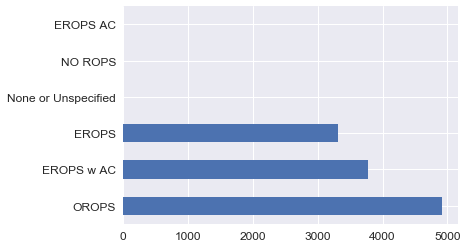

In [124]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [126]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.839783,0.279809
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.579073,0.267035
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.685985,0.227263


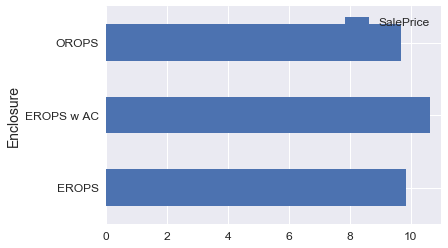

In [127]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

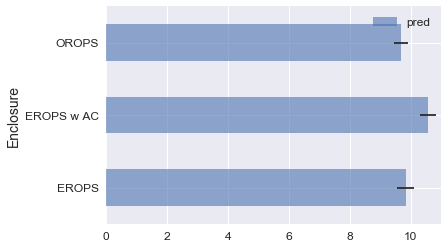

In [128]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

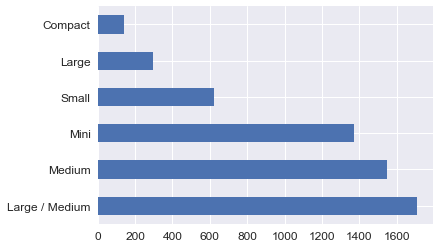

In [129]:
raw_valid.ProductSize.value_counts().plot.barh();

In [130]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.874696,0.370132
Large,10.470589,10.384481,0.360218
Large / Medium,10.691871,10.648120,0.301906
Medium,10.681511,10.623415,0.287308
Mini,9.535147,9.565160,0.252751
Small,10.324448,10.309598,0.308818


In [131]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.037483
Large             0.034688
Small             0.029954
Large / Medium    0.028353
Medium            0.027045
Mini              0.026424
dtype: float64

## Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know how it's making predictions. The most important way to see this is with feature importance.

In [137]:
fi = pd.DataFrame({'cols':df_trn.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [138]:
fi[:10]

,cols,imp
5,YearMade,0.171426
37,Coupler_System,0.094609
13,ProductSize,0.091050
14,fiProductClassDesc,0.083279
38,Grouser_Tracks,0.061830
63,saleElapsed,0.050065
2,ModelID,0.046599
10,fiSecondaryDesc,0.046124
39,Hydraulics_Flow,0.044514
19,Enclosure,0.039864


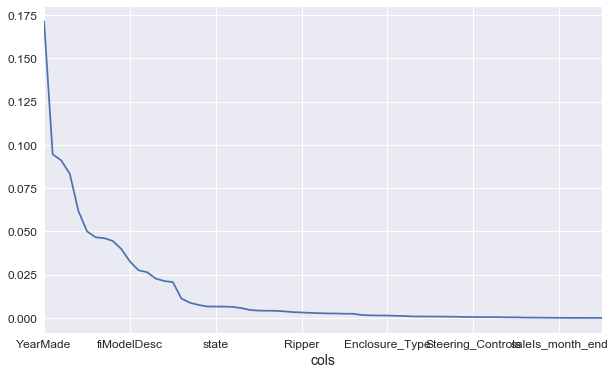

In [139]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

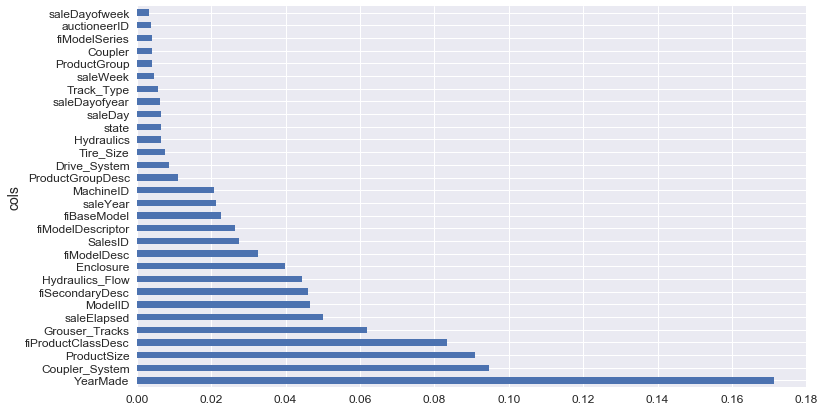

In [141]:
fi[:30].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [145]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

24

In [146]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [147]:
rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
print_score(rf)

RMSE Train: 0.2063744586952125 
 RMSE Valid: 0.24404456768513996 
 Score Train: 0.910988376889 
 Score Valid: 0.893638056639 
 OOB Score: 0.894730465553


In [150]:
fi1 = pd.DataFrame({'cols':df_keep.columns, 'imp':rf.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi1

,cols,imp
0,YearMade,0.170569
2,ProductSize,0.119160
1,Coupler_System,0.114322
3,fiProductClassDesc,0.079765
6,ModelID,0.059019
7,fiSecondaryDesc,0.053367
5,saleElapsed,0.053293
8,Hydraulics_Flow,0.047585
10,fiModelDesc,0.032833
12,fiModelDescriptor,0.032202


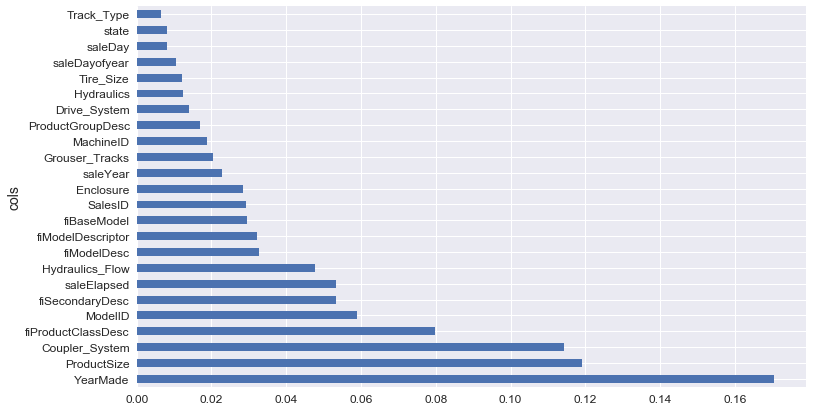

In [153]:
fi1.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

## One-hot encoding 

In [156]:
df_trn2, y_trn2, nas2 = proc_df(btrain, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
df_trn2.shape, y_trn2.shape, X_train.shape, X_valid.shape, y_train.shape

((401125, 173), (401125,), (389125, 173), (12000, 173), (389125,))

In [157]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train: 0.2072737616847086 
 RMSE Valid: 0.2544751700836201 
 Score Train: 0.910210927685 
 Score Valid: 0.884351820506 
 OOB Score: 0.892467712167


In [159]:
fi = pd.DataFrame({'cols':df_trn2.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi[:10]

,cols,imp
67,Enclosure_EROPS w AC,0.177564
5,YearMade,0.141845
48,ProductGroup_SSL,0.077512
55,ProductGroupDesc_Skid Steer Loaders,0.070754
2,ModelID,0.068189
12,fiProductClassDesc,0.052347
32,saleElapsed,0.051922
43,ProductSize_Mini,0.037911
9,fiSecondaryDesc,0.035489
7,fiModelDesc,0.025940


## Removing redundant features 

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.